Following the example from 4.1.2 pg.16 https://faculty.uca.edu/darrigo/Students/M4315/Fall%202005/sep-var.pdf

Solve a transient heat problem with a source

$u_{t}=u_{xx} + Q(x)$, $0 < x < L, t > 0$

$u(0, t)=0$, $u(L, t)=0$, $u(x, 0)=2x-x^2$, $L=2$, $Q(x)=1-|x-1|$

If considering the problem without the source term solutions would have the form:

$u(x, t) = \sum_{n=1}^\inf T_n(t)sin(\frac{n \pi x}{2})$

where

$T_n(t) = \frac{16(1-(-1)^n)}{n^3 \pi^3} e^{n^2 \pi^2 t/4}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
Ninf = 100

In [2]:
def Tn(t, n):
    return (16*(1-(-1)**n)/(n**3 * np.pi**3))*np.exp(-n**2 * np.pi**2 * t/4)

def u(x, t):
    out = 0
    for n in np.arange(1, Ninf):
        out += Tn(t, n)*np.sin(n*np.pi*x/2)
    return out

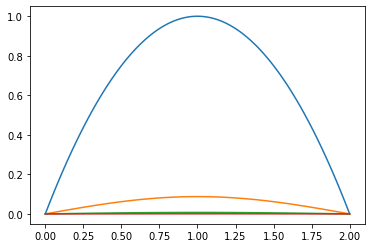

In [3]:
x = np.linspace(0, 2, 101)
plt.figure()
for t in [0, 1.0, 2.0, 3.0]:
    plt.plot(x, u(x, t))

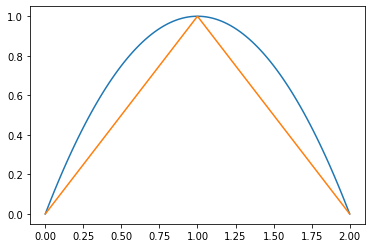

In [4]:
def IC(x):
    # Initial Condition
    return 2*x-x**2
def Q(x):
    # Source term
    return 1 - np.abs(x-1)
plt.figure()
plt.plot(x, IC(x))
plt.plot(x, Q(x))

In [5]:
def q(n):
    return 8*np.sin(n*np.pi/2)/(n**2 * np.pi**2)

def c(n):
    # There is a mistake in the text here cos(n Pi /2)
    return 16*(1 - np.cos(n*np.pi))/(n**3 * np.pi**3)

def b(n):
    return c(n) - 4*q(n)/(n**2 * np.pi**2)

def Tn_source(t, n):
    return (4*q(n)/(n**2 * np.pi**2)) + b(n)*np.exp(-n**2 * np.pi**2 * t/4)

def u_source(x, t):
    out = 0
    for n in np.arange(1, Ninf):
        out += Tn_source(t, n)*np.sin(n*np.pi*x/2)
    return out

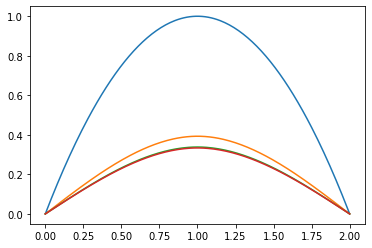

In [6]:
x = np.linspace(0, 2, 201)
plt.figure()
for t in [0, 1.0, 2.0, 3.0]:
    plt.plot(x, u_source(x, t))

In [7]:
import openpnm as op
wrk = op.Workspace()
#wrk.settings['loglevel'] = 20
spacing = 1e-2
L = 2.0
Nx = np.int(L/spacing)+1
net = op.network.Cubic(shape=[Nx, 1, 1], spacing=spacing)
# translate to origin
net['pore.coords'] -= np.array([spacing, spacing, spacing])/2
l = net['pore.coords'][:, 0].max() - net['pore.coords'][:, 0].min()
print(l)

2.0


In [8]:
net.add_boundary_pores(labels=['back', 'front'], spacing=0.0)

In [9]:
geo = op.geometry.GenericGeometry(network=net, pores=net.Ps, throats=net.Ts)
f=0.5
geo['pore.diameter'] = spacing
geo['throat.diameter'] = spacing
geo['throat.length'] = spacing
geo['throat.area'] = (f*spacing)**2
geo['pore.area'] = (f*spacing)**2
geo['pore.volume'] = geo['pore.area']*spacing
geo['throat.volume'] = 0.0

In [10]:
kappa = 1.0
phase = op.phases.GenericPhase(network=net)
phase['pore.conductivity'] = kappa
phys = op.physics.GenericPhysics(network=net, geometry=geo, phase=phase)
conc = 1.0  # mol/m^3
phys['throat.conductance'] = conc*kappa*geo['throat.area']/geo['throat.length']

In [11]:
Ps_x = net['pore.coords'][:, 0]
source = Q(Ps_x)*net['pore.volume']
Ps = net.pores('internal')
phys['pore.source.S1'] = 0.0
phys['pore.source.S2'] = source
phys['pore.source.rate'] = source


In [12]:
def run_transient(network, t_initial=0, t_final=3, t_step=0.01, t_output=0.1):
    alg = op.algorithms.TransientReactiveTransport(network=network)
    alg.setup(phase=phase, conductance='throat.conductance', quantity='pore.temperature',
              t_initial=t_initial, t_final=t_final, t_step=t_step, t_output=t_output,
              t_tolerance=1e-9, t_precision=12, rxn_tolerance=1e-9, t_scheme='implicit')
    alg.set_IC(values=IC(Ps_x))
    BP1 = net.pores('pore.front_boundary')
    BP2 = net.pores('pore.back_boundary')
    alg.set_value_BC(pores=BP1, values=0.0)
    alg.set_value_BC(pores=BP2, values=0.0)
    alg.set_source(propname='pore.source', pores=Ps)
    alg.run()
    return alg

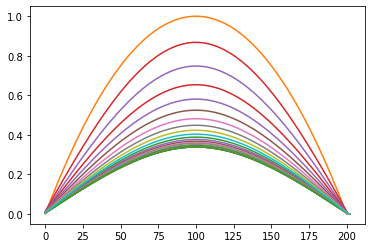

In [13]:
alg = run_transient(net)
res = alg.results()
times = list(res.keys())
times.sort()
plt.figure()
for time in times:
    plt.plot(alg[time])

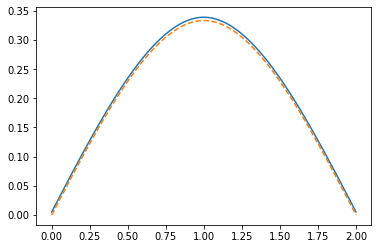

Error 1.64 %


In [14]:
plt.figure()
x = Ps_x[Ps]
A = alg['pore.temperature'][Ps]
B = u_source(x, 100)
plt.plot(x, A)
plt.plot(x, B, '--')
plt.show()
print('Error', np.around(100*np.max(A-B)/np.max(A), 2), '%')

In [15]:
phys['throat.conductance'] = phys['throat.conductance']*2.0
alg2 = run_transient(net)
phys['throat.conductance'] = phys['throat.conductance']*3.0/2.0
alg3 = run_transient(net)

$\hat{t} = t*l^2/\kappa$

In [16]:
def q(n):
    return 8*np.sin(n*np.pi/2)/(n**2 * np.pi**2)

def c(n):
    # There is a mistake in the text here cos(n Pi /2)
    return 16*(1 - np.cos(n*np.pi))/(n**3 * np.pi**3)

def b(n, Kappa):
    return c(n) - 4*q(n)/(Kappa * n**2 * np.pi**2)

def Tn_source(t, n, Kappa):
    return (4*q(n)/(Kappa * n**2 * np.pi**2)) + b(n, Kappa)*np.exp(-Kappa * n**2 * np.pi**2 * t/4)

def u_source(x, t, Kappa):
    out = 0
    for n in np.arange(1, Ninf):
        out += Tn_source(t, n, Kappa)*np.sin(n*np.pi*x/2)
    return out

<Figure size 432x288 with 0 Axes>

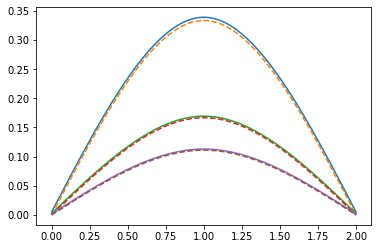

In [17]:
x = np.linspace(0, 2, Nx)
plt.figure()
plt.figure()
for Kappa, a in enumerate([alg, alg2, alg3]):
    plt.plot(x, a['pore.temperature'][Ps])
    plt.plot(x, u_source(x, t=1000, Kappa=Kappa+1.0), '--')